<a href="https://colab.research.google.com/github/somesh-kb/Liver-Disease-India-Data/blob/main/Liver_Disease_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
import pandas as pd
import numpy as np 

In [ ]:
file  = pd.read_csv(r'/content/mydrive/MyDrive/Indian-Liver-Disease-Dataset.csv')
df = pd.DataFrame(file)

In [ ]:
print(df.columns)

Index(['Age', 'Gender', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT', 'TP', 'ALB', 'AG',
       'Class'],
      dtype='object')


In [ ]:
print(df.dtypes)

Age         int64
Gender     object
TB        float64
DB        float64
AAP         int64
SGPT        int64
SGOT        int64
TP        float64
ALB       float64
AG        float64
Class       int64
dtype: object


In [ ]:
print(df.shape)

(583, 11)


In [ ]:
df['Gender'].value_counts()

Male      441
Female    142
Name: Gender, dtype: int64

In [ ]:
print(df['Age'].value_counts())
print(df['Age'].describe())

60    34
45    25
50    23
42    21
38    21
      ..
10     1
8      1
84     1
6      1
90     1
Name: Age, Length: 72, dtype: int64
count    583.000000
mean      44.746141
std       16.189833
min        4.000000
25%       33.000000
50%       45.000000
75%       58.000000
max       90.000000
Name: Age, dtype: float64


44.74614065180103 16.18983330469438


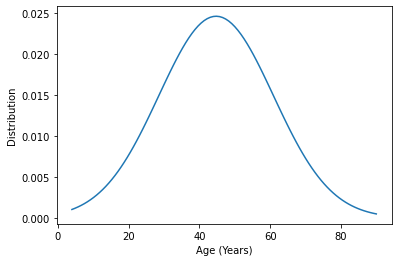

In [ ]:
import scipy.stats 
import matplotlib.pyplot as plt 

mean = df['Age'].mean()
std = df['Age'].std()

print(mean,std)

min = 4
max= 90 

x = np.linspace(min,max,100)
y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y)
plt.xlabel('Age (Years)')
plt.ylabel('Distribution')
plt.show()

In [ ]:
gender = pd.get_dummies(df['Gender'])

print(gender)

df_new = pd.concat([gender,df],axis=1,join='inner')

print(df_new.columns)

     Female  Male
0         1     0
1         0     1
2         0     1
3         0     1
4         0     1
..      ...   ...
578       0     1
579       0     1
580       0     1
581       0     1
582       0     1

[583 rows x 2 columns]
Index(['Female', 'Male', 'Age', 'Gender', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT',
       'TP', 'ALB', 'AG', 'Class'],
      dtype='object')


In [ ]:
df_new.drop('Gender',inplace=True,axis=1)

print(df_new.columns)



Index(['Female', 'Male', 'Age', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT', 'TP', 'ALB',
       'AG', 'Class'],
      dtype='object')


In [ ]:
print(df_new.describe())

for col in df_new.columns:
  print(col,df_new[col].isnull().sum())

           Female        Male         Age  ...         ALB          AG       Class
count  583.000000  583.000000  583.000000  ...  583.000000  579.000000  583.000000
mean     0.243568    0.756432   44.746141  ...    3.141852    0.947064    1.286449
std      0.429603    0.429603   16.189833  ...    0.795519    0.319592    0.452490
min      0.000000    0.000000    4.000000  ...    0.900000    0.300000    1.000000
25%      0.000000    1.000000   33.000000  ...    2.600000    0.700000    1.000000
50%      0.000000    1.000000   45.000000  ...    3.100000    0.930000    1.000000
75%      0.000000    1.000000   58.000000  ...    3.800000    1.100000    2.000000
max      1.000000    1.000000   90.000000  ...    5.500000    2.800000    2.000000

[8 rows x 12 columns]
Female 0
Male 0
Age 0
TB 0
DB 0
AAP 0
SGPT 0
SGOT 0
TP 0
ALB 0
AG 4
Class 0


In [ ]:
df_new['AG'] = df_new.fillna(df_new['AG'].mean()) 

#**Univariate Feature Selction**

In [188]:
X = df_new[['Female', 'Male', 'Age', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT', 'TP', 'ALB', 'AG']]
Y = df_new['Class']

from sklearn.feature_selection import SelectKBest# as gus, chi2

skb = SelectKBest(chi2,k='all')
test = skb.fit(X,Y)

scores = np.sort(test.scores_)
df_score = pd.DataFrame(scores,X.columns)#,columns=['Features','chi2 score'])
print(df_score)
#print(test.pvalues_)

                   0
Female      0.129627
Male        0.964518
Age         2.995441
TB          2.995441
DB          3.053371
AAP        64.315174
SGPT      187.005784
SGOT      329.873827
TP       4039.855702
ALB      6421.919946
AG      10203.328978


In [ ]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.svm import SVC  

svc = SVC(kernel='poly',degree=2)

scores =[]
for i in range(X.shape[1]):
  score = cross_val_score(svc,X,Y, cv=(ShuffleSplit(len(X),10,.2)),n_jobs=-1)
  scores.append((np.mean(score),X.columns[i]))
print(scores)

df_score=pd.DataFrame(scores)
print(df_score)

[(0.7154373927958834, 'Female'), (0.7205831903945111, 'Male'), (0.7114922813036021, 'Age'), (0.7144082332761578, 'TB'), (0.7169811320754716, 'DB'), (0.70926243567753, 'AAP'), (0.7180102915951972, 'SGPT'), (0.7262435677530017, 'SGOT'), (0.7109777015437393, 'TP'), (0.7262435677530018, 'ALB'), (0.7111492281303603, 'AG')]
           0       1
0   0.715437  Female
1   0.720583    Male
2   0.711492     Age
3   0.714408      TB
4   0.716981      DB
5   0.709262     AAP
6   0.718010    SGPT
7   0.726244    SGOT
8   0.710978      TP
9   0.726244     ALB
10  0.711149      AG


#  **Pearson Correlation** 
#Check multicollinearity

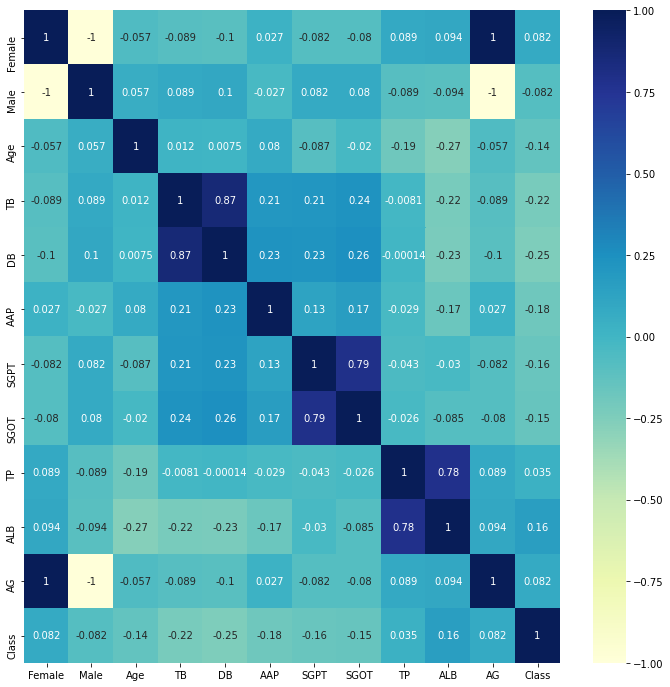

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df_new.corr(),cmap='YlGnBu',annot=True)
plt.show()

**Feature Selection** : Combining the chi2 score and the correlation matrix, we selected independent features.

In [203]:
X = df_new[[ 'AAP', 'SGPT', 'ALB','AG']]
            
Y = df_new['Class']

# To verify the correlation

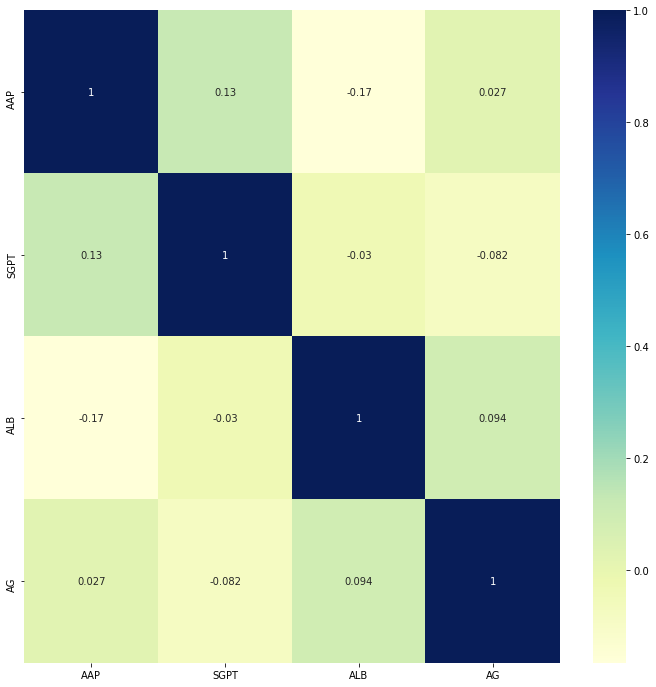

In [204]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),annot=True,cmap='YlGnBu')
plt.show()

# Split the whole dataset into training and test data

In [205]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X_new,Y,test_size=0.25,random_state=21)

print(X_train.shape)

(437, 11)


Two classification models employed: **1) RandomForestClassfier** --> A tree based model
**2) Support Vector Machine Classfier** --> Distance based model 

Hyperparameter optimization performed using two methods:

1) RandomizedSearchCV

2) Bayesian Optimization using **"Hyperopt"**


# **RandomizedSearchCV** for hyperparameter tuning

---




In [206]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(random_state=11)

print(rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)>


In [207]:
from sklearn.model_selection import RandomizedSearchCV 

bootstrap = [True]

criterion = ['gini', 'entropy']

max_depth = [int(x) for x in range(2,91,1)]

max_features = ['auto', 'sqrt', 'log2']

#min_impurity_decrease = [j for j in np.arange(0,0.5,0.1)]

#min_samples_split = [int(x) for x in np.arange(2,11,1)]

max_leaf_nodes = [int(x) for x in np.arange(2,41,1)]

n_estimators = [int(x) for x in np.arange(50,1001,10)]

param_grid = {'bootstrap':bootstrap,'criterion':criterion,'n_estimators':n_estimators, 
              'max_depth':max_depth,'max_features':max_features,'max_leaf_nodes':max_leaf_nodes}

rs_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, n_jobs=-1, 
                           random_state=21, return_train_score=True, cv=10)

rs_cv.fit(X_train,Y_train)

print(rs_cv.best_params_)

{'n_estimators': 140, 'max_leaf_nodes': 40, 'max_features': 'auto', 'max_depth': 52, 'criterion': 'entropy', 'bootstrap': True}


In [208]:
rf = RandomForestClassifier(n_estimators=140,max_leaf_nodes=40,max_features='auto', 
                            max_depth=52, criterion='entropy',bootstrap=True)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)

In [209]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

print(classification_report(Y_test,Y_pred))

print(confusion_matrix(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.82      0.90      0.85       115
           2       0.40      0.26      0.31        31

    accuracy                           0.76       146
   macro avg       0.61      0.58      0.58       146
weighted avg       0.73      0.76      0.74       146

[[103  12]
 [ 23   8]]


# **SVM Classifier**

In [212]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

Xsc_train = std_scale.fit_transform(X_train)
Xsc_test = std_scale.fit_transform(X_test)
 

In [213]:
from sklearn.svm import SVC 

svc = SVC()


print(svc.get_params)

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>


In [214]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']

degree=[int(x) for x in np.arange(2,7,1)]

gamma = ['auto','scale']#, 'ball_tree', 'kd_tree', 'brute']

C = [x for x in np.arange(0.5,10,0.1)]

#leaf_size = (int(x) for x in np.arange(10,102,2))

svm_param = {'C':C, 'kernel':kernel,'degree':degree,'gamma':gamma}#,'algorithm':algorithm, 'leaf_size':leaf_size}

rs_cv = RandomizedSearchCV(estimator=svc,param_distributions=svm_param,n_iter=100,n_jobs=-1,cv=10,
                           return_train_score=True,random_state=21)

rs_cv.fit(Xsc_train,Y_train)

print(rs_cv.best_params_)

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 2.8999999999999995}


In [215]:
svc = SVC(kernel='rbf', gamma = 'scale', degree=2, C=2.8999999999999995 )

svc.fit(Xsc_train,Y_train)

Y_pred = svc.predict(Xsc_test)

In [216]:
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.81      0.93      0.87       115
           2       0.43      0.19      0.27        31

    accuracy                           0.77       146
   macro avg       0.62      0.56      0.57       146
weighted avg       0.73      0.77      0.74       146

[[107   8]
 [ 25   6]]


# **HYPEROPT: Tree Parzen Estimator** 

In [ ]:
!pip install hyperopt

In [217]:
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold #,StratifiedKFold
from sklearn.metrics import accuracy_score

#rf = RandomForestClassifier(random_state=12)

def objective(params):
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    params['max_depth'] = int(params['max_depth'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    #params['subsample'] = float(params['subsample'])
    #params['colsample_bytree'] = float(params['colsample_bytree'])
    #params['min_child_weight'] = float(params['min_child_weight'])
    #params['objective'] = 'reg:linear'
    params['criterion'] = 'gini'
    params['max_features'] = 'auto'
    #params['silent'] = 1
#    params['nthread'] = 10
    #params['seed'] = 2020 #ramdom number seed
   
    global X, y, heatName, best
   
    RANDOM_STATE = 2
    n_folds = 10
    errors = []
   
    kf = KFold(n_folds, random_state=RANDOM_STATE, shuffle = True)
    print('..........................')
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]
        #features = list(X.columns.values)
        #for i in range(len(features)):
            #features[i] = features[i].replace("[","")
            #features[i] = features[i].replace("]","")
        #xgtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=features)
        #X_val2 = xgb.DMatrix(X_val, label=Y_val, feature_names=features)
        #watchlist = [(xgtrain, 'train'), (X_val2, 'eval')]
        model = RandomForestClassifier(**params,n_jobs=-1,random_state=1141 )
        model.fit(X_train,Y_train)
        Y_val_pred = model.predict(X_val)#, ntree_limit=model.n_estimators)
        errors.append(accuracy_score(Y_val,Y_val_pred,normalize=True))
        print('RF',errors[-1])
   
    error = np.mean(errors)
   
    print("############### Error: {0}".format(error))
    print("############### Prms: ", params)
    print('..........................')
   
    return {
        'loss': error,
        'status': STATUS_OK,
        'eval_time': time.time(),
        }
xgb_space = {
        'n_estimators':hp.quniform('n_estimators',50,3000,10),
        'max_depth':hp.quniform('max_depth',2,30,1), 
        'max_leaf_nodes':hp.quniform('max_leaf_nodes',2,30,1),
        #'min_samples_leaf':hp.quniform('min_samples_leaf',0,0.5,0.005),
        #'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        #'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
        #'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
        #'reg_lambda': hp.quniform('lamdba', 0,1,0.1)
}
                                 
trials = Trials()
best = fmin(objective,
    space=xgb_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)
print(best)

..........................
RF
0.7966101694915254
RF
0.6101694915254238
RF
0.6610169491525424
RF
0.6896551724137931
RF
0.7241379310344828
RF
0.6896551724137931
RF
0.7413793103448276
RF
0.6896551724137931
RF
0.7758620689655172
RF
0.603448275862069
############### Error: 0.6981589713617767
############### Prms: 
{'max_depth': 28, 'max_leaf_nodes': 14, 'criterion': 'gini', 'max_features': 'auto'}
..........................
..........................
RF
0.7796610169491526
RF
0.6271186440677966
RF
0.6779661016949152
RF
0.6724137931034483
RF
0.7413793103448276
RF
0.7068965517241379
RF
0.7413793103448276
RF
0.6724137931034483
RF
0.7758620689655172
RF
0.603448275862069
############### Error: 0.6998538866160139
############### Prms: 
{'max_depth': 7, 'max_leaf_nodes': 12, 'criterion': 'gini', 'max_features': 'auto'}
..........................
..........................
RF
0.8135593220338984
RF
0.6101694915254238
RF
0.6610169491525424
RF
0.6724137931034483
RF
0.7068965517241379
RF
0.7068965517241

In [220]:
rf = RandomForestClassifier(max_depth= 5, max_leaf_nodes=30, n_estimators=1870,criterion='gini')
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)

In [221]:
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.83      0.90      0.87       115
           2       0.48      0.32      0.38        31

    accuracy                           0.78       146
   macro avg       0.65      0.61      0.63       146
weighted avg       0.76      0.78      0.76       146

[[104  11]
 [ 21  10]]


In [ ]:
!pip install shap

     |████████████████████████████████| 327kB 7.5MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463897 sha256=319847c812d6c4e39f658ace414e678048bdfca0078ff606620baaf6a7e44cf1
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


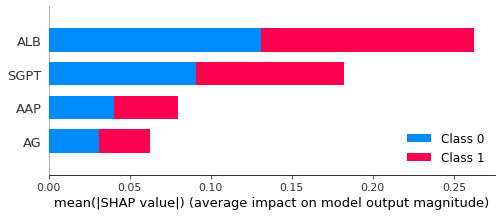

In [237]:
import shap 
X = df_new[['AAP', 'SGPT', 'ALB','AG']]
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X,check_additivity=False)
shap.summary_plot(shap_values,X,plot_type='bar',feature_names=X.columns)

In [233]:
print(shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value[0],shap_values[0],feature_names=X.columns)


[array([[ 0.00329655, -0.00196492, -0.10803379, -0.02015701],
       [-0.04874665, -0.08940248, -0.12932243, -0.03759792],
       [-0.03575029, -0.09153935, -0.12823656, -0.0355657 ],
       ...,
       [-0.03595672, -0.09153935, -0.12823656, -0.0355657 ],
       [-0.03923794, -0.09006444, -0.12678605, -0.0406837 ],
       [-0.02528124, -0.08513983, -0.17360125, -0.05721816]]), array([[-0.00329655,  0.00196492,  0.10803379,  0.02015701],
       [ 0.04874665,  0.08940248,  0.12932243,  0.03759792],
       [ 0.03575029,  0.09153935,  0.12823656,  0.0355657 ],
       ...,
       [ 0.03595672,  0.09153935,  0.12823656,  0.0355657 ],
       [ 0.03923794,  0.09006444,  0.12678605,  0.0406837 ],
       [ 0.02528124,  0.08513983,  0.17360125,  0.05721816]])]
